**NARVAL column-based model on QUBICC data**

<a id='import_cell_1'></a>

In [1]:
# Ran with Max Mem = 200 GB on a GPU node

import sys
import os 
import numpy as np
import pandas as pd
import xarray as xr
import importlib
import resource
import gc
# importlib.reload(my_classes)

from tensorflow.keras.models import load_model

root_path = '/pf/b/b309170'
# Add path with my_classes to sys.path
sys.path.insert(0, root_path + '/workspace_icon-ml/cloud_cover_parameterization/')

from my_classes import read_mean_and_std
from my_classes import load_data

import matplotlib.pyplot as plt

<a id='import_cell_2'></a>

In [2]:
model_path = os.path.join(root_path,
                          'workspace_icon-ml/cloud_cover_parameterization/grid_column_based/saved_models')

*Load models*

<a id='load_models'></a>

In [3]:
model_1 = load_model(os.path.join(model_path, 'model_grid_column_based_final_1.h5'))
model_2 = load_model(os.path.join(model_path, 'model_grid_column_based_final_2.h5'))

**First visualization method** (Third in the other notebook) <br>
Hovmöller diagram (time on x-axis with vertical layers on y-axis and NN ensemble mean clc in color) <br>
Note that I start with the third visualization method here, since the original data is loaded in the third visualization method in the NARVAL-interpretation notebook.

In [35]:
# Example file: int_var_hc2_02_p1m_ta_ml_20041107T100000Z.nc
os.listdir(os.path.join(root_path, 'my_work/QUBICC/data_var_vertinterp/'))

['rho',
 'zg',
 'clw',
 'cli',
 'cl',
 'fr_seaice',
 'ta',
 '.ipynb_checkpoints',
 'pfull',
 'hus',
 'fr_land',
 'fr_lake',
 'variables.txt',
 'first_timestep']

In [36]:
# Get not_nan quickly
path = os.path.join(root_path, 'my_work/QUBICC/data_var_vertinterp/')
DS = xr.open_mfdataset(path+'cl/int_var_hc2_02_p1m_cl_ml_20041107T100000Z.nc', combine='by_coords')
da = DS.cl.values
not_nan = ~np.isnan(da[0,30,:])

*Loading Nov, 2nd: 2004110200* 

Careful with the order of the variables!

<a id='order_of_vars'></a>

In [4]:
all_features = ['hus', 'clw', 'cli', 'ta', 'pfull', 'rho', 'zg', 'fr_lake']
order_of_vars = ['hus', 'clw', 'cli', 'ta', 'pfull', 'rho', 'zg', 'fr_lake', 'cl']

<a id='load_data_one_day'></a>

In [7]:
# Loads the NARVAL data into the data_dict dictionary
data_dict = load_data(source='qubicc', days='nov_2nd', order_of_vars=order_of_vars)

hus
clw
cli
ta
pfull
rho
cl


In [9]:
TIME_STEPS = data_dict['cl'].shape[0]
HORIZ_FIELDS = data_dict['cl'].shape[2]
VERT_LAYERS = 31

#Reshaping into nd-arrays of equaling shapes
data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), TIME_STEPS, axis=0)
data_dict['fr_lake'] = np.repeat(np.expand_dims(data_dict['fr_lake'], 0), TIME_STEPS, axis=0)

#Convert cl-information from [0, 1] to [0, 100]
data_dict['cl'] = data_dict['cl']*100

In [10]:
[print(key + ': ' + str(data_dict[key].shape)) for key in data_dict.keys()];

hus: (240, 31, 14826)
qclw_phy: (240, 31, 14826)
cli: (240, 31, 14826)
ta: (240, 31, 14826)
pfull: (240, 31, 14826)
rho: (240, 31, 14826)
zg: (240, 31, 14826)
fr_lake: (240, 14826)
cl: (240, 31, 14826)


In [11]:
# One sample should contain a column of information
data_dict_reshaped = {}
for key in data_dict.keys():
    if data_dict[key].shape[1] == VERT_LAYERS:  
        for i in range(4, VERT_LAYERS):
            new_key = '{}{}{:d}'.format(key,'_',i)
            data_dict_reshaped[new_key] = np.reshape(data_dict[key][:,i,:], -1)
    else:
        data_dict_reshaped[key] = np.reshape(data_dict[key], -1)

# Remove constant columns
del data_dict_reshaped['zg_4']
del data_dict_reshaped['zg_5']
del data_dict_reshaped['zg_6']
del data_dict_reshaped['qclw_phy_4']

In [12]:
#Converting dict into a DataFrame-object 
df = pd.DataFrame.from_dict(data_dict_reshaped)
df.head()

,hus_4,hus_5,hus_6,hus_7,hus_8,hus_9,hus_10,hus_11,hus_12,hus_13,...,cl_21,cl_22,cl_23,cl_24,cl_25,cl_26,cl_27,cl_28,cl_29,cl_30
0,0.000003,0.000003,0.000003,0.000003,0.000004,0.000009,0.000017,0.000030,0.000041,0.000069,...,30.544990,40.332326,28.934924,32.750630,37.925359,38.130018,34.581223,29.875829,18.199687,9.858818
1,0.000003,0.000003,0.000003,0.000003,0.000004,0.000009,0.000014,0.000029,0.000038,0.000066,...,16.334608,18.270084,42.947067,31.849299,16.515103,18.510937,20.142757,21.579363,19.753153,13.281139
2,0.000003,0.000003,0.000003,0.000003,0.000005,0.000008,0.000015,0.000028,0.000039,0.000068,...,15.602576,8.048617,25.990061,26.341673,27.921167,17.791706,12.368120,8.596151,8.493715,4.239652
3,0.000003,0.000003,0.000003,0.000003,0.000005,0.000009,0.000020,0.000031,0.000039,0.000067,...,11.225246,13.098842,28.917473,41.343928,53.564405,51.691546,38.289089,28.464830,23.764443,28.514858
4,0.000003,0.000003,0.000003,0.000003,0.000004,0.000008,0.000017,0.000027,0.000038,0.000068,...,5.358869,4.734292,10.760189,55.640544,31.894501,0.395661,0.440578,0.101948,2.889028,0.920734


*Scaling the data*

<a id='means_stds'></a>

In [6]:
mean_1, std_1 = read_mean_and_std(os.path.join(model_path, 'model_grid_column_based_final_1.txt'))
mean_2, std_2 = read_mean_and_std(os.path.join(model_path, 'model_grid_column_based_final_2.txt'))

mean_1 = np.concatenate((mean_1, np.zeros(27)))
mean_2 = np.concatenate((mean_2, np.zeros(27)))
std_1 = np.concatenate((std_1, np.ones(27)))
std_2 = np.concatenate((std_2, np.ones(27)))

In [14]:
# Note that after standardization the mean and variance are not 0 and 1 respectively 
# as the data values above 21km are still in the data
df_1 = ((df - mean_1)/std_1).to_numpy()
df_2 = ((df - mean_2)/std_2).to_numpy()

*Drawing the diagram*

In [44]:
df_1.shape

(355824, 213)

In [45]:
# Draw the diagram
# All vertical layers from first time step
pred_clc_mat = np.zeros((TIME_STEPS, 27))
for i in range(TIME_STEPS):
    # Mean prediction for a specific time step 
    pred_1 = model_1.predict(df_1[1024*i: 1024*(i+1), :-27]) # Maybe I have the indexing wrong after all
    pred_adj_1 = np.mean(np.minimum(np.maximum(pred_1, 0), 100), axis=0)
    pred_2 = model_2.predict(df_2[1024*i: 1024*(i+1), :-27]) 
    pred_adj_2 = np.mean(np.minimum(np.maximum(pred_2, 0), 100), axis=0)
    pred_clc_mat[i,:] = 1/2*(pred_adj_1+pred_adj_2)       

In [46]:
data_clc_mat = np.zeros((TIME_STEPS, 27))
for i in range(TIME_STEPS):
    # Mean cloud cover for a specific time step 
    data_clc_1 = np.mean(df_1[1024*i: 1024*(i+1), -27:], axis=0)
    data_clc_2 = np.mean(df_2[1024*i: 1024*(i+1), -27:], axis=0)
    data_clc_mat[i,:] = 1/2*(data_clc_1+data_clc_2)

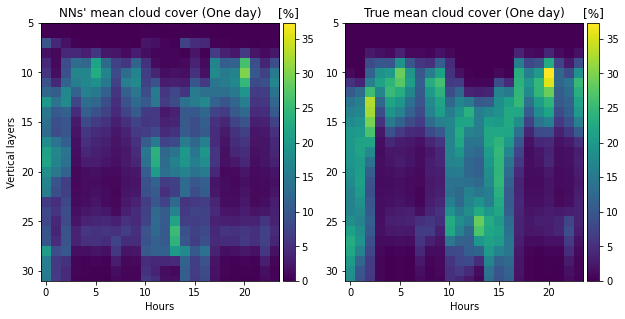

In [47]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

matrix = np.zeros((TIME_STEPS, 32))
matrix_data = np.zeros((TIME_STEPS, 32))
matrix[:, 5:] = pred_clc_mat
matrix_data[:, 5:] = data_clc_mat

# Crucial so that the colorbar will actually match both plots
vmax = np.maximum(np.max(pred_clc_mat), np.max(data_clc_mat))
vmin = np.minimum(np.min(pred_clc_mat), np.min(data_clc_mat))

# t = np.linspace(1, 25, 25)
# v = np.linspace(9, 75)
# T, V = np.meshgrid(t, v)
fig = plt.figure(figsize=(10, 10))
ax_2 = fig.add_subplot(122, xlabel='Hours', ylim=[31, 5], title='True mean cloud cover (One day)')
ims_2 = ax_2.imshow(np.transpose(matrix_data),vmin=vmin, vmax=vmax)
# Colorbar axes
divider = make_axes_locatable(ax_2)
cax_2 = divider.append_axes("right", size="5%", pad=0.05)
cb_2 = fig.colorbar(ims_2, cax=cax_2)
cb_2.ax.set_title('[%]')
#fig.colorbar(ims_2)
ax_1 = fig.add_subplot(121, xlabel='Hours', ylabel='Vertical layers', ylim=[31, 5], 
                       title='NNs\' mean cloud cover (One day)')
ims_1 = ax_1.imshow(np.transpose(matrix),vmin=vmin, vmax=vmax)
# Colorbar axes
divider = make_axes_locatable(ax_1)
cax_1 = divider.append_axes("right", size="5%", pad=0.05)
cb_1 = fig.colorbar(ims_1, cax=cax_1)
#fig.colorbar(ims_1)
cb_1.ax.set_title('[%]')
# fig.savefig('../figures/qubicc_offline_testing_hovmoeller.pdf')

**Plot the timeseries for one specific grid column** <br>
I can do it for August, 2016 (December, 2013 has some tricky days and I need a continuous stretch of days)

In [48]:
# Show memory usage: 1295604
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

132959772

<a id='load_data_nov_20s'></a>

In [5]:
# Load all days
# Uses 25 GB of memory

# Loads the NARVAL data into the data_dict dictionary
data_dict = load_data(source='qubicc', days='nov_20s', order_of_vars=order_of_vars)

hus
clw
cli
ta
pfull
rho
cl


In [50]:
# When deleting variables and running the garbage-collector, it doesn't show that 
# resources were freed up, still they are freed up for other objects that need to be stored
del da
del DS

gc.collect()

# Show memory usage: 26271440
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

132959772

<a id='reshape_1'></a>

In [7]:
TIME_STEPS = data_dict['cl'].shape[0]
HORIZ_FIELDS = data_dict['cl'].shape[2]
VERT_LAYERS = 31

#Reshaping into nd-arrays of equaling shapes
data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), TIME_STEPS, axis=0)
data_dict['fr_lake'] = np.repeat(np.expand_dims(data_dict['fr_lake'], 0), TIME_STEPS, axis=0)

#Convert cl-information from [0, 1] to [0, 100]
data_dict['cl'] = data_dict['cl']*100

<a id='reshape_2'></a>

In [8]:
# One sample should contain a column of information
data_dict_reshaped = {}
for key in data_dict.keys():
    if data_dict[key].shape[1] == VERT_LAYERS:  
        for i in range(4, VERT_LAYERS):
            new_key = '{}{}{:d}'.format(key,'_',i)
            data_dict_reshaped[new_key] = np.reshape(data_dict[key][:,i,:], -1)
    else:
        data_dict_reshaped[key] = np.reshape(data_dict[key], -1)

# Remove constant fields
del data_dict_reshaped['zg_4']
del data_dict_reshaped['zg_5']
del data_dict_reshaped['zg_6']
del data_dict_reshaped['qclw_phy_4']

<a id='df'></a>

In [24]:
#Converting dict into a DataFrame-object 
df = pd.DataFrame.from_dict(data_dict_reshaped)
df.head()

,hus_4,hus_5,hus_6,hus_7,hus_8,hus_9,hus_10,hus_11,hus_12,hus_13,...,cl_21,cl_22,cl_23,cl_24,cl_25,cl_26,cl_27,cl_28,cl_29,cl_30
0,0.000003,0.000002,0.000002,0.000002,0.000003,0.000005,0.000012,0.000020,0.000027,0.000028,...,84.243959,94.370000,82.966293,41.469790,17.946481,7.399493,2.384823,1.150777,0.472649,0.247434
1,0.000003,0.000002,0.000002,0.000002,0.000003,0.000005,0.000009,0.000009,0.000014,0.000026,...,68.954975,64.979431,47.198379,33.513621,28.399671,27.056316,29.915883,29.390891,29.115236,28.204804
2,0.000003,0.000002,0.000002,0.000002,0.000003,0.000005,0.000011,0.000017,0.000019,0.000021,...,68.009247,75.961264,77.743913,73.674731,60.523137,47.309607,38.885462,23.034606,21.947135,21.947135
3,0.000003,0.000002,0.000002,0.000002,0.000003,0.000005,0.000009,0.000010,0.000013,0.000027,...,4.828412,6.850665,5.522256,8.050275,6.681550,5.936035,5.930494,6.297135,8.356290,8.356290
4,0.000003,0.000002,0.000002,0.000002,0.000003,0.000005,0.000012,0.000023,0.000039,0.000062,...,0.000000,0.000000,0.911849,8.661865,19.687788,24.796515,29.099680,35.025653,37.980613,39.343292


<a id='df_scaled'></a>

In [25]:
# Scale the data
df_scaled_1 = ((df - mean_1)/std_1).to_numpy()
df_scaled_2 = ((df - mean_2)/std_2).to_numpy()

In [55]:
# Take a random horizontal field
m = 900

indices = [] 
for i in range(TIME_STEPS):
    indices.append(m+i*HORIZ_FIELDS)

timesteps = np.arange(TIME_STEPS)
true_clc = data_dict['cl'][:,:,m] #time x vert x hor
pred_clc = np.maximum(np.minimum(model_1.predict(df_scaled_1[indices, :-27]),100),0)  #Have to reconstruct the mth field

In [56]:
true_clc.shape

(720, 31)

In [57]:
matrix_data.shape

(24, 32)

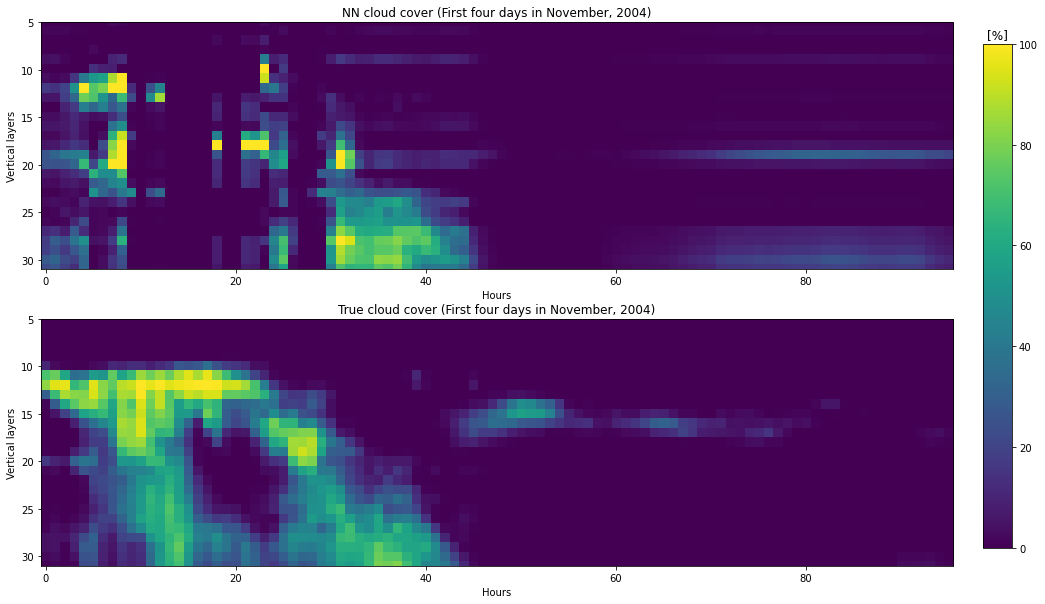

In [58]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

matrix = np.zeros((96, 32)) #np.zeros((745, 31))
matrix_data = np.zeros((96, 32))
matrix[:, 5:] = pred_clc[:96]
matrix_data[:, 5:] = true_clc[:96, 4:]
# Crucial so that the colorbar will actually match both plots
vmax = np.maximum(np.max(matrix), np.max(matrix_data))
vmin = np.minimum(np.min(matrix), np.min(matrix_data))
# t = np.linspace(1, 25, 25)
# v = np.linspace(9, 75)
# T, V = np.meshgrid(t, v)
fig = plt.figure(figsize=(20,10))
ax_2 = fig.add_subplot(212, xlabel='Hours', ylabel='Vertical layers', ylim=[31, 5], 
                       title='True cloud cover (First four days in November, 2004)')
im = ax_2.imshow(np.transpose(matrix_data),vmin=vmin, vmax=vmax)
# # Colorbar axes
# divider = make_axes_locatable(ax_2)
# cax_2 = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(ims_2, cax=cax_2)
#fig.colorbar(ims_2)
ax_1 = fig.add_subplot(211, xlabel='Hours', ylabel='Vertical layers', ylim=[31, 5], 
                       title='NN cloud cover (First four days in November, 2004)')
im = ax_1.imshow(np.transpose(matrix),vmin=vmin, vmax=vmax)
# # Colorbar axes
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])

#([0.85, 0.15, 0.05, 0.7])
# divider = make_axes_locatable(cbar_ax)
# cax_1 = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('[%]')
# fig.colorbar(ims_1)
# fig.savefig('../figures/qubicc_offline_testing_column_in_beginning_of_november.pdf')

**Second visualization method** (First in the other notebook) <br>
Samples on x-axis and cloud cover on y-axis

<a id='input_test'></a>

In [26]:
# Maintaining the test(set)-nomenclature
input_test_1 = df_scaled_1[:, :-27]
input_test_2 = df_scaled_2[:, :-27]

output_test = df_scaled_1[:, -27:]

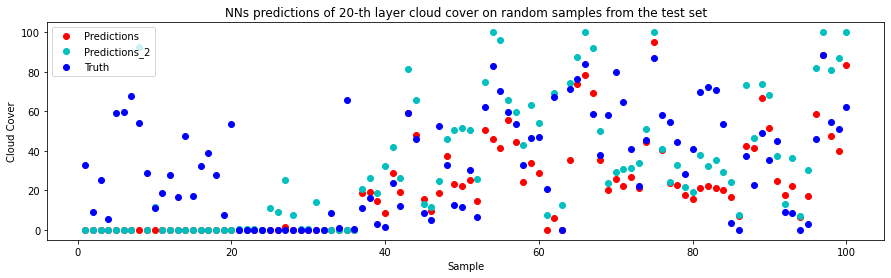

In [60]:
# Note that the differences in predictions really stem from the differences in the models 
# (and not from the different standardization methods)

no_samples = 100
layer = 20
clc_pred_1 = np.maximum(np.minimum(model_1.predict(input_test_1[-no_samples:])[:,layer],100),0)
clc_pred_2 = np.maximum(np.minimum(model_2.predict(input_test_2[-no_samples:])[:,layer],100),0)
clc_true = output_test[-no_samples:, layer]
a = np.linspace(1, no_samples, no_samples)

fig = plt.figure(figsize=(15,4))
# Careful with saying that it's the 20th layer. It's from the perspective of an ICON-A grid with model height at 21km.
ax = fig.add_subplot(111, title='NNs predictions of %d-th layer cloud cover on random samples from the test set'%layer, 
                     xlabel='Sample', ylabel='Cloud Cover')
ax.plot(a, clc_pred_1, 'ro')
ax.plot(a, clc_pred_2, 'co')
ax.plot(a, clc_true, 'bo')
ax.legend(['Predictions', 'Predictions_2', 'Truth'])
# fig.savefig('../figures/qubicc_offline_testing_predictions_random_samples.pdf')

**Third visualization method** (Second in the other notebook) <br>
Mean profile of Cloud Cover on x-axis with Vertical Layer on y-axis. This time I can use the test set.

<a id='predicting'></a>

In [27]:
# Vertical layers
a = np.linspace(5, 31, 27)
# Cloud cover means for first model
clc_data_mean = []
for i in range(27):
    clc_data_mean.append(np.mean(output_test[:, i], dtype=np.float64))
# Cloud cover means for second model
clc_data_mean_2 = []
for i in range(27):
    clc_data_mean_2.append(np.mean(output_test[:, i], dtype=np.float64))
# Predicted cloud cover means
pred_adj = np.minimum(np.maximum(model_1.predict(input_test_1), 0), 100)
clc_mean = np.mean(pred_adj, axis=0, dtype=np.float64)
pred_adj_2 = np.minimum(np.maximum(model_2.predict(input_test_2), 0), 100)
clc_mean_2 = np.mean(pred_adj_2, axis=0, dtype=np.float64)

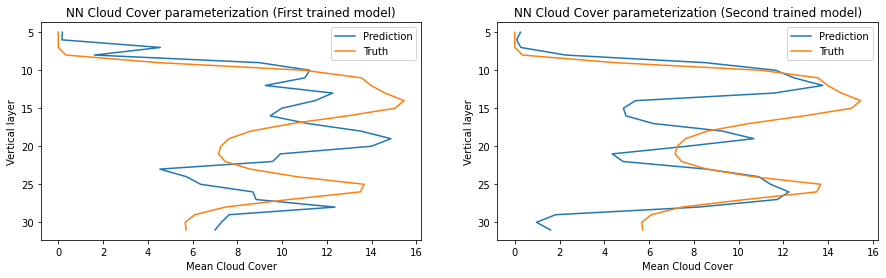

In [14]:
fig = plt.figure(figsize=(15,4))
# For model
ax_1 = fig.add_subplot(121, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (First trained model)')
ax_1.plot(clc_mean, a)
ax_1.plot(clc_data_mean, a)
plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
# For model_2
ax_2 = fig.add_subplot(122, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (Second trained model)')
ax_2.plot(clc_mean_2, a)
ax_2.plot(clc_data_mean_2, a)
plt.gca().invert_yaxis()
ax_2.legend(['Prediction', 'Truth'])
# fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_NNs.pdf')

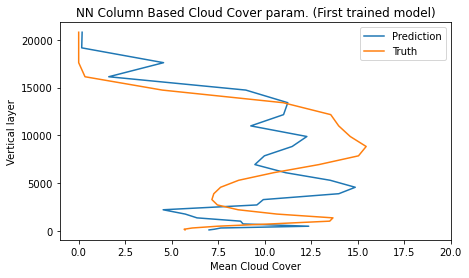

In [21]:
# With height vertical axis
#Taken from the grid cell based model
zg_mean = [20784.62706138, 19153.33733398, 17603.95786796, 16133.9890368 ,
       14740.72817851, 13421.56030093, 12174.49640667, 10997.54366598,
        9888.86828393,  8846.77905352,  7869.70937839,  6956.19812463,
        6104.87029163,  5314.41907809,  4583.59136617,  3911.17886673,
        3296.01709893,  2736.9940178 ,  2233.06954874,  1783.30740375,
        1386.91651733,  1043.31024674,   752.18615016,   513.63653294,
         328.34456911,   198.27747065,   127.38265241]

fig = plt.figure(figsize=(7,4))
# For model
ax_1 = fig.add_subplot(111, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Column Based Cloud Cover param. (First trained model)', xlim=[-1, 20])
ax_1.plot(clc_mean, zg_mean)
ax_1.plot(clc_data_mean, zg_mean)
# plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
# # For model_2
# ax_2 = fig.add_subplot(122, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
#                        title='NN Cloud Cover parameterization (Second trained model)', xlim=[-1, 20])
# ax_2.plot(clc_mean_2, zg_mean)
# ax_2.plot(clc_data_mean_2, zg_mean)
# # plt.gca().invert_yaxis()
# ax_2.legend(['Prediction', 'Truth'])
fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_NNs_height_vert_axis_1st_model.pdf')

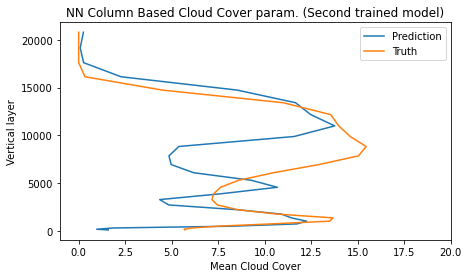

In [22]:
# With height vertical axis
#Taken from the grid cell based model
zg_mean = [20784.62706138, 19153.33733398, 17603.95786796, 16133.9890368 ,
       14740.72817851, 13421.56030093, 12174.49640667, 10997.54366598,
        9888.86828393,  8846.77905352,  7869.70937839,  6956.19812463,
        6104.87029163,  5314.41907809,  4583.59136617,  3911.17886673,
        3296.01709893,  2736.9940178 ,  2233.06954874,  1783.30740375,
        1386.91651733,  1043.31024674,   752.18615016,   513.63653294,
         328.34456911,   198.27747065,   127.38265241]

fig = plt.figure(figsize=(7,4))
# # For model
# ax_1 = fig.add_subplot(121, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
#                        title='NN Cloud Cover parameterization (First trained model)', xlim=[-1, 20])
# ax_1.plot(clc_mean, zg_mean)
# ax_1.plot(clc_data_mean, zg_mean)
# # plt.gca().invert_yaxis()
# ax_1.legend(['Prediction', 'Truth'])
# For model_2
ax_2 = fig.add_subplot(111, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Column Based Cloud Cover param. (Second trained model)', xlim=[-1, 20])
ax_2.plot(clc_mean_2, zg_mean)
ax_2.plot(clc_data_mean_2, zg_mean)
# plt.gca().invert_yaxis()
ax_2.legend(['Prediction', 'Truth'])
fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_NNs_height_vert_axis_2nd_model.pdf')

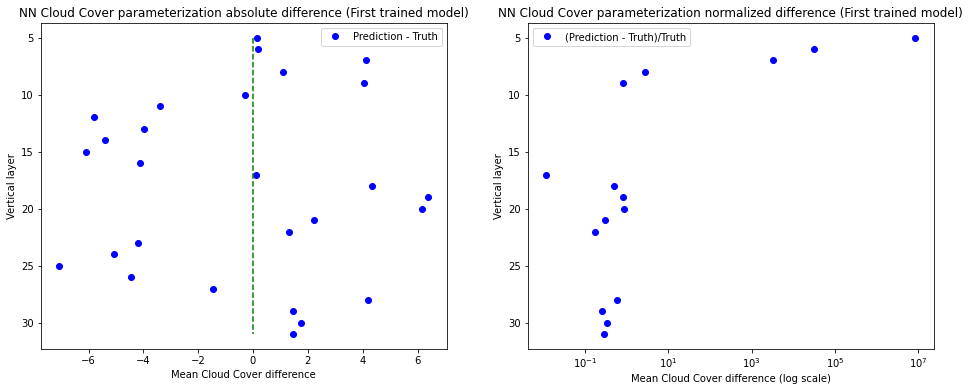

In [63]:
# Nando's suggestion: Panel showing the differences (absolute and/or normalised with the truth cloud cover)

fig = plt.figure(figsize=(16,6))
# For model
ax_1 = fig.add_subplot(121, xlabel='Mean Cloud Cover difference', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization absolute difference (First trained model)')
ax_1.plot(clc_mean - clc_data_mean, a, 'bo')
ax_1.plot(0*a, a, 'g--')
plt.gca().invert_yaxis()
ax_1.legend(['Prediction - Truth'])

ax_2 = fig.add_subplot(122, xscale='log', xlabel='Mean Cloud Cover difference (log scale)', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization normalized difference (First trained model)')
ax_2.plot((clc_mean - clc_data_mean)/clc_data_mean, a, 'bo')
# ax_2.plot(0*a, a, 'g--')
plt.gca().invert_yaxis()
ax_2.legend(['(Prediction - Truth)/Truth'])

*Computing the standard error of regression per vertical layer* <br>
The standard error of regression (ser) is defined as the square root of the variance of the residuals. Actually it's the same as the RMSE.

In [64]:
# Nando's suggestion: use a metric to test significance. SER is what comes closest, but significance is rather for classification problems

ser = []
ser_2 = []
for i in range(27):
    ser.append(np.sqrt(np.mean((pred_adj[:, i] - output_test[:, i])**2)))
    ser_2.append(np.sqrt(np.mean((pred_adj_2[:, i] - output_test[:, i])**2)))

ser_total = np.sqrt(np.var(pred_adj - output_test))
ser_total_2 = np.sqrt(np.var(pred_adj_2 - output_test))

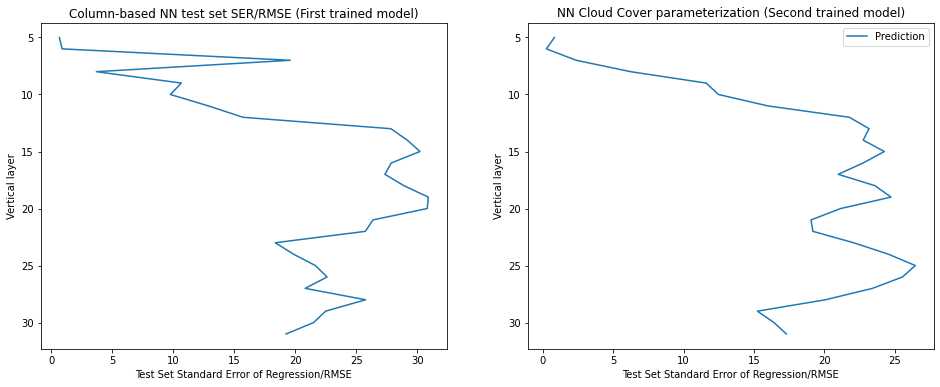

In [65]:
fig = plt.figure(figsize=(16,6))
# For model
ax_1 = fig.add_subplot(121, xlabel='Test Set Standard Error of Regression/RMSE', ylabel='Vertical layer', 
                       title='Column-based NN test set SER/RMSE (First trained model)')
ax_1.plot(ser, a)
# ax_1.plot(np.mean(ser)*np.ones(len(a)), a, 'g--')
plt.gca().invert_yaxis()
# ax_1.legend(['Prediction - Truth'])

ax_2 = fig.add_subplot(122, xlabel='Test Set Standard Error of Regression/RMSE', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (Second trained model)')
ax_2.plot(ser_2, a)
plt.gca().invert_yaxis()
# plt.savefig('../figures/qubicc_test_set_rmse_ser.pdf')
ax_2.legend(['Prediction', 'Truth'])

In [66]:
print('{}{:.3f}'.format('The total SER of the first model is ', ser_total))
print('{}{:.3f}'.format('The total SER of the second model is ', ser_total_2))

The total SER of the first model is 22.221
The total SER of the second model is 19.361


#### **Fourth visualization method** <br>
Interpret NN parameterizations on QUBICC data in NARVAL region

We need to run the following cells first: <br>
[import_cell_1](#import_cell_1), 
[import_cell_2](#import_cell_2),
[load_models](#load_models),
[order_of_vars](#order_of_vars),
[load_data_nov_20s](#load_data_nov_20s),
[means_stds](#means_stds),
[reshape_1](#reshape_1),

Here might be a better way to execute jupyter cells in a prescribed order: https://stackoverflow.com/questions/47567834/execute-a-jupyter-notebook-cell-programmatically (I couldn't get it running)

In [34]:
for keys in data_dict.keys():
    print(data_dict[keys].shape)

(240, 31, 14826)
(240, 31, 14826)
(240, 31, 14826)
(240, 31, 14826)
(240, 31, 14826)
(240, 31, 14826)
(240, 31, 14826)
(240, 14826)
(240, 31, 14826)


We need to:
1) Reinsert nans that arose through overlapping topography during vertical interpolation into the QUBICC data
2) Set fields from outside the NARVAL region to nan
3) We select the fields where the lowermost levels are not nan

Step 1): So that we have 20480 horizontal fields and can compare that directly to the R02B04-grid. <br>
Note that data_dict.shape[2] != data_dict_new.shape[2]

Step 3) should leave us with only those grid columns that are in the NARVAL region and that have been coarse-grained without producing nans in QUBICC 

*1. Overlapping nans*

In [35]:
path = '/pf/b/b309170/my_work/QUBICC/data_var_vertinterp/cli'
file_name = 'int_var_hc2_02_p1m_cli_ml_20041112T200000Z_R02B04.nc'

In [36]:
DS = xr.open_dataset(os.path.join(path, file_name))
da_cli = DS.cli.values
overlap_nans = np.isnan(da_cli[0,30,:])
overlap_nans.shape

(20480,)

In [37]:
# Create new data_dict with correct dimensionality
data_dict_new = {}
for key in data_dict.keys():
    if key != 'fr_lake':
        data_dict_new[key] = np.zeros((data_dict[key].shape[0], data_dict[key].shape[1], 
                                      len(overlap_nans)))
    else:
        data_dict_new[key] = np.zeros((data_dict[key].shape[0], len(overlap_nans)))

In [38]:
# ov_f is a temporary array that is adjusted depending on the key, time step and vertical layer
ov_f = np.array(overlap_nans, dtype=float)
ov_f[np.where(ov_f == 1)] = np.nan # Every True in overlap_nans will be a nan
ov_f_copy = ov_f.copy() # Need this otherwise ov_f == 0 will never be true anymore when beginning the loop

for key in data_dict.keys():
    for i in range(TIME_STEPS):
        if key != 'fr_lake':
            for j in range(VERT_LAYERS):
                ov_f_copy[np.where(ov_f == 0)] = data_dict[key][i,j,:] 
                data_dict_new[key][i,j,:] = ov_f_copy   
        else:
            ov_f_copy[np.where(ov_f == 0)] = data_dict[key][i,:] 
            data_dict_new[key][i,:] = ov_f_copy   

In [39]:
for keys in data_dict_new.keys():
    print(data_dict_new[keys].shape)

(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 20480)
(240, 31, 20480)


*2. Which of these entries are from the NARVAL region?*

In [40]:
# Narval region: 68W-15E, 10S-20N
lon_lower_bound = -68/180*np.pi
lon_upper_bound = 15/180*np.pi
lat_lower_bound = -10/90*np.pi/2
lat_upper_bound = 20/90*np.pi/2

In [41]:
#Load native grid
qubicc_r02b04_path = '/pf/b/b309170/my_work/QUBICC/grids/icon_grid_0013_R02B04_G.nc'
qubicc_r02b04 = xr.open_dataset(qubicc_r02b04_path)

qubicc_lat = qubicc_r02b04.lat_cell_centre.values
qubicc_lon = qubicc_r02b04.lon_cell_centre.values

In [42]:
# Keep only the narval region
for key in data_dict.keys():
    for i in range(TIME_STEPS):
        for k in range(20480): # Horizontal fields
            # If k-th entry of the qubicc r02b04 grid is in narval region
            if not (lat_lower_bound <= qubicc_lat[k] <= lat_upper_bound and lon_lower_bound <= qubicc_lon[k] <= lon_upper_bound):
                if key != 'fr_lake':
                    for j in range(VERT_LAYERS):
                        data_dict_new[key][i,j,k] = np.nan  
                else:
                    data_dict_new[key][i,k] = np.nan 

*3. We select the fields where the lowermost levels are not nan*

In [43]:
not_nan = ~np.isnan(data_dict_new['hus'][0,30,:])

In [44]:
# Create new data_dict with correct dimensionality
data_dict_selected_fields = {}
for key in data_dict.keys():
    if key != 'fr_lake':
        data_dict_selected_fields[key] = data_dict_new[key][:,:,not_nan]
    else:
        data_dict_selected_fields[key] = data_dict_new[key][:,not_nan]

Now we can use [reshape_2](#reshape_2) as above:

In [45]:
# One sample should contain a column of information
data_dict_reshaped = {}
for key in data_dict_selected_fields.keys():
    if data_dict_selected_fields[key].shape[1] == VERT_LAYERS:  
        for i in range(4, VERT_LAYERS):
            new_key = '{}{}{:d}'.format(key,'_',i)
            data_dict_reshaped[new_key] = np.reshape(data_dict_selected_fields[key][:,i,:], -1)
    else:
        data_dict_reshaped[key] = np.reshape(data_dict_selected_fields[key], -1)

# Remove constant fields
del data_dict_reshaped['zg_4']
del data_dict_reshaped['zg_5']
del data_dict_reshaped['zg_6']
del data_dict_reshaped['qclw_phy_4']

Run [df](#df), [df_scaled](#df_scaled), [input_test](#input_test) and [predicting](#predicting)! 

Finally we can plot the results:

In [51]:
a

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31.])

In [53]:
#Taken from the grid cell based model
zg_mean = [20784.62706138, 19153.33733398, 17603.95786796, 16133.9890368 ,
       14740.72817851, 13421.56030093, 12174.49640667, 10997.54366598,
        9888.86828393,  8846.77905352,  7869.70937839,  6956.19812463,
        6104.87029163,  5314.41907809,  4583.59136617,  3911.17886673,
        3296.01709893,  2736.9940178 ,  2233.06954874,  1783.30740375,
        1386.91651733,  1043.31024674,   752.18615016,   513.63653294,
         328.34456911,   198.27747065,   127.38265241]

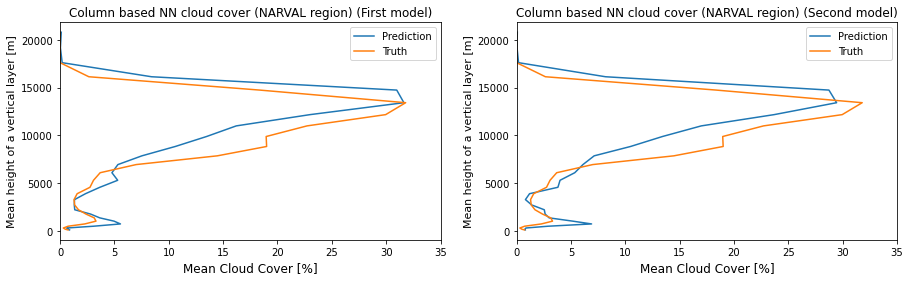

In [54]:
fig = plt.figure(figsize=(15,4))
# For model
ax_1 = fig.add_subplot(121, title='Column based NN cloud cover (NARVAL region) (First model)', xlim=[0, 35])
ax_1.set_xlabel('Mean Cloud Cover [%]', fontsize = 12)
ax_1.set_ylabel('Mean height of a vertical layer [m]', fontsize = 11)
ax_1.plot(clc_mean, zg_mean)
ax_1.plot(clc_data_mean, zg_mean)
# plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
# For model_2
ax_2 = fig.add_subplot(122, title='Column based NN cloud cover (NARVAL region) (Second model)', xlim=[0, 35])
ax_2.set_xlabel('Mean Cloud Cover [%]', fontsize = 12)
ax_2.set_ylabel('Mean height of a vertical layer [m]', fontsize = 11)
ax_2.plot(clc_mean_2, zg_mean)
ax_2.plot(clc_data_mean_2, zg_mean)
# plt.gca().invert_yaxis()
ax_2.legend(['Prediction', 'Truth'])

fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_NARVAL_region_nov_20s.pdf')

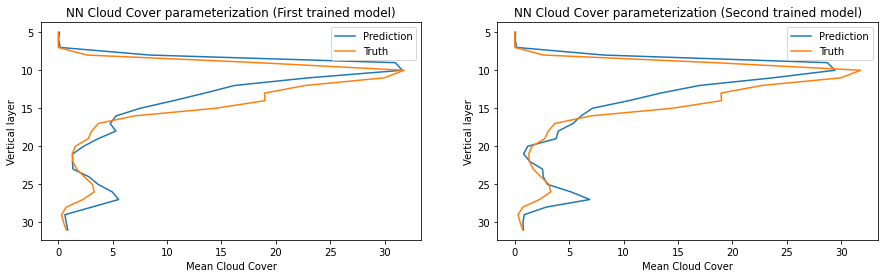

In [26]:
fig = plt.figure(figsize=(15,4))
# For model
ax_1 = fig.add_subplot(121, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (First trained model)')
ax_1.plot(clc_mean, a)
ax_1.plot(clc_data_mean, a)
plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
# For model_2
ax_2 = fig.add_subplot(122, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (Second trained model)')
ax_2.plot(clc_mean_2, a)
ax_2.plot(clc_data_mean_2, a)
plt.gca().invert_yaxis()
ax_2.legend(['Prediction', 'Truth'])
fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_NNs_NARVAL_region_nov_20s.pdf')

The plot **qubicc_offline_testing_mean_cloud_cover_NNs_NARVAL_region_alleged.pdf** is actually evaluated on the region of the globe shown in the pdf alleged_narval_region_on_qubicc_r2b4_grid.pdf which can be found in additional_content/comparing_icon_grids. The issue arose due to differences between the R2B4 grid I coarse-grained Qubicc to (0013) and the R2B4 grid I coarse-grained Narval to (0005).

#### **Fifth visualization** <br>
Interpret NN parameterizations on QUBICC data in i) the tropical zone and ii) over the Southern Ocean

We need to run the following cells first: <br>
[import_cell_1](#import_cell_1), 
[import_cell_2](#import_cell_2),
[load_models](#load_models),
[order_of_vars](#order_of_vars),
[load_data_nov_20s](#load_data_nov_20s),
[means_stds](#means_stds),
[reshape_1](#reshape_1),

Here might be a better way to execute jupyter cells in a prescribed order: https://stackoverflow.com/questions/47567834/execute-a-jupyter-notebook-cell-programmatically (I couldn't get it running)

In [8]:
for keys in data_dict.keys():
    print(data_dict[keys].shape)

(240, 31, 14826)
(240, 31, 14826)
(240, 31, 14826)
(240, 31, 14826)
(240, 31, 14826)
(240, 31, 14826)
(240, 31, 14826)
(240, 14826)
(240, 31, 14826)


We need to:
1) Reinsert nans that arose through overlapping topography during vertical interpolation into the QUBICC data
2) Set fields from outside the NARVAL region to nan
3) We select the columns where the lowermost levels are not nan

Step 1): So that we have 20480 horizontal fields and can compare that directly to the R02B04-grid. <br>
Note that data_dict.shape[2] != data_dict_new.shape[2]

Step 3) should leave us with only those grid columns that are in the NARVAL region and that have been coarse-grained without producing nans in QUBICC 

*1. Overlapping nans*

In [9]:
path = '/pf/b/b309170/my_work/QUBICC/data_var_vertinterp/cli'
file_name = 'int_var_hc2_02_p1m_cli_ml_20041112T200000Z_R02B04.nc'

In [10]:
DS = xr.open_dataset(os.path.join(path, file_name))
da_cli = DS.cli.values
overlap_nans = np.isnan(da_cli[0,30,:])
overlap_nans.shape

(20480,)

In [11]:
# Create new data_dict with correct dimensionality
data_dict_new = {}
for key in data_dict.keys():
    if key != 'fr_lake':
        data_dict_new[key] = np.zeros((data_dict[key].shape[0], data_dict[key].shape[1], 
                                      len(overlap_nans)))
    else:
        data_dict_new[key] = np.zeros((data_dict[key].shape[0], len(overlap_nans)))

In [12]:
# ov_f is a temporary array that is adjusted depending on the key, time step and vertical layer
ov_f = np.array(overlap_nans, dtype=float)
ov_f[np.where(ov_f == 1)] = np.nan # Every True in overlap_nans will be a nan
ov_f_copy = ov_f.copy() # Need this otherwise ov_f == 0 will never be true anymore when beginning the loop

for key in data_dict.keys():
    for i in range(TIME_STEPS):
        if key != 'fr_lake':
            for j in range(VERT_LAYERS):
                ov_f_copy[np.where(ov_f == 0)] = data_dict[key][i,j,:] 
                data_dict_new[key][i,j,:] = ov_f_copy   
        else:
            ov_f_copy[np.where(ov_f == 0)] = data_dict[key][i,:] 
            data_dict_new[key][i,:] = ov_f_copy   

In [13]:
for keys in data_dict_new.keys():
    print(data_dict_new[keys].shape)

(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 20480)
(240, 31, 20480)


*2. Which of these entries are from the tropical zone?*

In [45]:
# Tropical zone: 23.4365S-23.4365N (Narval region: 68W-15E, 10S-20N)
lat_lower_bound = -23.4365/90*np.pi/2
lat_upper_bound = 23.4365/90*np.pi/2

In [46]:
#Load native grid
qubicc_r02b04_path = '/pf/b/b309170/my_work/QUBICC/grids/icon_grid_0013_R02B04_G.nc'
qubicc_r02b04 = xr.open_dataset(qubicc_r02b04_path)

qubicc_lat = qubicc_r02b04.lat_cell_centre.values
qubicc_lon = qubicc_r02b04.lon_cell_centre.values

In [47]:
# Keep only the tropical zone
for key in data_dict.keys():
    for i in range(TIME_STEPS):
        for k in range(20480): # Horizontal fields
            # If k-th entry of the qubicc r02b04 grid is in the tropical zone
            if not (lat_lower_bound <= qubicc_lat[k] <= lat_upper_bound):
                if key != 'fr_lake':
                    for j in range(VERT_LAYERS):
                        data_dict_new[key][i,j,k] = np.nan  
                else:
                    data_dict_new[key][i,k] = np.nan 

*3. We select the fields where the lowermost levels are not nan*

In [48]:
not_nan = ~np.isnan(data_dict_new['hus'][0,30,:])

In [49]:
# Create new data_dict with correct dimensionality
data_dict_selected_fields = {}
for key in data_dict.keys():
    if key != 'fr_lake':
        data_dict_selected_fields[key] = data_dict_new[key][:,:,not_nan]
    else:
        data_dict_selected_fields[key] = data_dict_new[key][:,not_nan]

Now we can use [reshape_2](#reshape_2) as above:

In [50]:
# One sample should contain a column of information
data_dict_reshaped = {}
for key in data_dict_selected_fields.keys():
    if data_dict_selected_fields[key].shape[1] == VERT_LAYERS:  
        for i in range(4, VERT_LAYERS):
            new_key = '{}{}{:d}'.format(key,'_',i)
            data_dict_reshaped[new_key] = np.reshape(data_dict_selected_fields[key][:,i,:], -1)
    else:
        data_dict_reshaped[key] = np.reshape(data_dict_selected_fields[key], -1)

# Remove constant fields
del data_dict_reshaped['zg_4']
del data_dict_reshaped['zg_5']
del data_dict_reshaped['zg_6']
del data_dict_reshaped['clw_4']

Run [df](#df), [df_scaled](#df_scaled), [input_test](#input_test) and [predicting](#predicting)! 

Finally we can plot the results:

In [72]:
#Taken from the grid cell based model
zg_mean = [20784.62706138, 19153.33733398, 17603.95786796, 16133.9890368 ,
       14740.72817851, 13421.56030093, 12174.49640667, 10997.54366598,
        9888.86828393,  8846.77905352,  7869.70937839,  6956.19812463,
        6104.87029163,  5314.41907809,  4583.59136617,  3911.17886673,
        3296.01709893,  2736.9940178 ,  2233.06954874,  1783.30740375,
        1386.91651733,  1043.31024674,   752.18615016,   513.63653294,
         328.34456911,   198.27747065,   127.38265241]

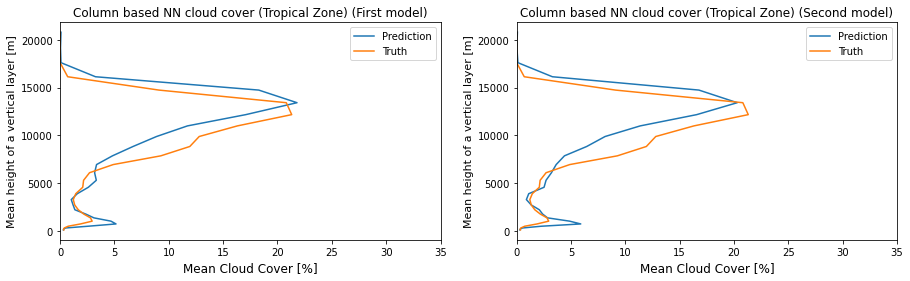

In [29]:
fig = plt.figure(figsize=(15,4))
# For model
ax_1 = fig.add_subplot(121, title='Column based NN cloud cover (Tropical Zone) (First model)', xlim=[0, 35])
ax_1.set_xlabel('Mean Cloud Cover [%]', fontsize = 12)
ax_1.set_ylabel('Mean height of a vertical layer [m]', fontsize = 11)
ax_1.plot(clc_mean, zg_mean)
ax_1.plot(clc_data_mean, zg_mean)
# plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
# For model_2
ax_2 = fig.add_subplot(122, title='Column based NN cloud cover (Tropical Zone) (Second model)', xlim=[0, 35])
ax_2.set_xlabel('Mean Cloud Cover [%]', fontsize = 12)
ax_2.set_ylabel('Mean height of a vertical layer [m]', fontsize = 11)
ax_2.plot(clc_mean_2, zg_mean)
ax_2.plot(clc_data_mean_2, zg_mean)
# plt.gca().invert_yaxis()
ax_2.legend(['Prediction', 'Truth'])

fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_tropical_zone_nov_20s.pdf')

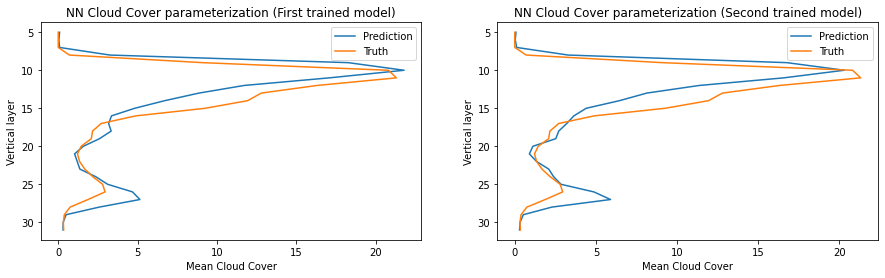

In [30]:
fig = plt.figure(figsize=(15,4))
# For model
ax_1 = fig.add_subplot(121, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (First trained model)')
ax_1.plot(clc_mean, a)
ax_1.plot(clc_data_mean, a)
plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
# For model_2
ax_2 = fig.add_subplot(122, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (Second trained model)')
ax_2.plot(clc_mean_2, a)
ax_2.plot(clc_data_mean_2, a)
plt.gca().invert_yaxis()
ax_2.legend(['Prediction', 'Truth'])
fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_NNs_tropical_zone_nov_20s.pdf')

In [56]:
print(list(clc_mean))
print(list(clc_mean_2))
print(clc_data_mean)

[0.0830069967937231, 0.040800196420027676, 0.08290710448933951, 3.2566537111850598, 18.27758666632784, 21.796215987889923, 17.081248717187368, 11.719494487920251, 8.875220542054564, 6.713485541599305, 4.821128661184571, 3.3560105002225677, 3.176920606541401, 3.3334624814603604, 2.599479383028398, 1.5816709690321926, 1.0303861569271455, 1.1953291089867817, 1.362783708709738, 2.361591489844654, 3.115600738989329, 4.680634554238793, 5.146340912824326, 2.5826638027729807, 0.49255474515344305, 0.31294062989429644, 0.3031957793137779]
[0.0716537802517169, 0.027724395932385053, 0.11657892279496622, 3.2907616835485296, 16.769535002058365, 20.295815077419128, 16.565026506585976, 11.367963489444206, 8.138467260786403, 6.449232809175227, 4.400663072426225, 3.6391619416900673, 3.2030462351237614, 2.7064176134301876, 2.5244531619405155, 1.1139142488352292, 0.8984174852618348, 1.3429531669898649, 2.090321306202629, 2.3915148689922687, 2.847537385194399, 4.872578278783512, 5.900159167231567, 2.283187

**Southern Ocean** <br>
Initialize data_dict like in **Fifth visualization** above

In [58]:
# Create new data_dict with correct dimensionality
data_dict_new = {}
for key in data_dict.keys():
    if key != 'fr_lake':
        data_dict_new[key] = np.zeros((data_dict[key].shape[0], data_dict[key].shape[1], 
                                      len(overlap_nans)))
    else:
        data_dict_new[key] = np.zeros((data_dict[key].shape[0], len(overlap_nans)))

In [59]:
# ov_f is a temporary array that is adjusted depending on the key, time step and vertical layer
ov_f = np.array(overlap_nans, dtype=float)
ov_f[np.where(ov_f == 1)] = np.nan # Every True in overlap_nans will be a nan
ov_f_copy = ov_f.copy() # Need this otherwise ov_f == 0 will never be true anymore when beginning the loop

for key in data_dict.keys():
    for i in range(TIME_STEPS):
        if key != 'fr_lake':
            for j in range(VERT_LAYERS):
                ov_f_copy[np.where(ov_f == 0)] = data_dict[key][i,j,:] 
                data_dict_new[key][i,j,:] = ov_f_copy   
        else:
            ov_f_copy[np.where(ov_f == 0)] = data_dict[key][i,:] 
            data_dict_new[key][i,:] = ov_f_copy   

In [60]:
for keys in data_dict_new.keys():
    print(data_dict_new[keys].shape)

(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 31, 20480)
(240, 20480)
(240, 31, 20480)


*2. Which of these entries are from the Southern Ocean?*

In [16]:
# Southern Ocean: South of 60S (Narval region: 68W-15E, 10S-20N)
lat_upper_bound = -60/90*np.pi/2

In [17]:
#Load native grid
qubicc_r02b04_path = '/pf/b/b309170/my_work/QUBICC/grids/icon_grid_0013_R02B04_G.nc'
qubicc_r02b04 = xr.open_dataset(qubicc_r02b04_path)

qubicc_lat = qubicc_r02b04.lat_cell_centre.values
qubicc_lon = qubicc_r02b04.lon_cell_centre.values

In [18]:
# Keep only the Southern Ocean
for key in data_dict.keys():
    for i in range(TIME_STEPS):
        for k in range(20480): # Horizontal fields
            # If k-th entry of the qubicc r02b04 grid is over the Southern Ocean
            if not (qubicc_lat[k] <= lat_upper_bound):
                if key != 'fr_lake':
                    for j in range(VERT_LAYERS):
                        data_dict_new[key][i,j,k] = np.nan  
                else:
                    data_dict_new[key][i,k] = np.nan 

*3. We select the fields where the lowermost levels are not nan*

In [19]:
not_nan = ~np.isnan(data_dict_new['hus'][0,30,:])

In [20]:
# Create new data_dict with correct dimensionality
data_dict_selected_fields = {}
for key in data_dict.keys():
    if key != 'fr_lake':
        data_dict_selected_fields[key] = data_dict_new[key][:,:,not_nan]
    else:
        data_dict_selected_fields[key] = data_dict_new[key][:,not_nan]

Now we can use [reshape_2](#reshape_2) as above:

In [23]:
# One sample should contain a column of information
data_dict_reshaped = {}
for key in data_dict_selected_fields.keys():
    if data_dict_selected_fields[key].shape[1] == VERT_LAYERS:  
        for i in range(4, VERT_LAYERS):
            new_key = '{}{}{:d}'.format(key,'_',i)
            data_dict_reshaped[new_key] = np.reshape(data_dict_selected_fields[key][:,i,:], -1)
    else:
        data_dict_reshaped[key] = np.reshape(data_dict_selected_fields[key], -1)

# Remove constant fields
del data_dict_reshaped['zg_4']
del data_dict_reshaped['zg_5']
del data_dict_reshaped['zg_6']
del data_dict_reshaped['clw_4']

Run [df](#df), [df_scaled](#df_scaled), [input_test](#input_test) and [predicting](#predicting)! 

Finally we can plot the results:

In [73]:
a

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31.])

In [74]:
#Taken from the grid cell based model
zg_mean = [20784.62706138, 19153.33733398, 17603.95786796, 16133.9890368 ,
       14740.72817851, 13421.56030093, 12174.49640667, 10997.54366598,
        9888.86828393,  8846.77905352,  7869.70937839,  6956.19812463,
        6104.87029163,  5314.41907809,  4583.59136617,  3911.17886673,
        3296.01709893,  2736.9940178 ,  2233.06954874,  1783.30740375,
        1386.91651733,  1043.31024674,   752.18615016,   513.63653294,
         328.34456911,   198.27747065,   127.38265241]

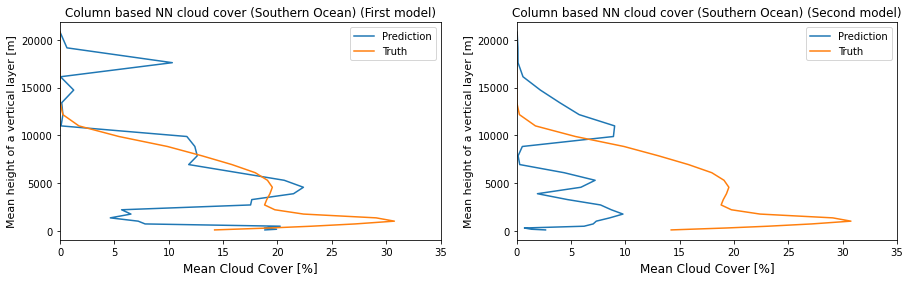

In [75]:
fig = plt.figure(figsize=(15,4))
# For model
ax_1 = fig.add_subplot(121, title='Column based NN cloud cover (Southern Ocean) (First model)', xlim=[0, 35])
ax_1.set_xlabel('Mean Cloud Cover [%]', fontsize = 12)
ax_1.set_ylabel('Mean height of a vertical layer [m]', fontsize = 11)
ax_1.plot(clc_mean, zg_mean)
ax_1.plot(clc_data_mean, zg_mean)
# plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
# For model_2
ax_2 = fig.add_subplot(122, title='Column based NN cloud cover (Southern Ocean) (Second model)', xlim=[0, 35])
ax_2.set_xlabel('Mean Cloud Cover [%]', fontsize = 12)
ax_2.set_ylabel('Mean height of a vertical layer [m]', fontsize = 11)
ax_2.plot(clc_mean_2, zg_mean)
ax_2.plot(clc_data_mean_2, zg_mean)
# plt.gca().invert_yaxis()
ax_2.legend(['Prediction', 'Truth'])

fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_southern_ocean_nov_20s.pdf')

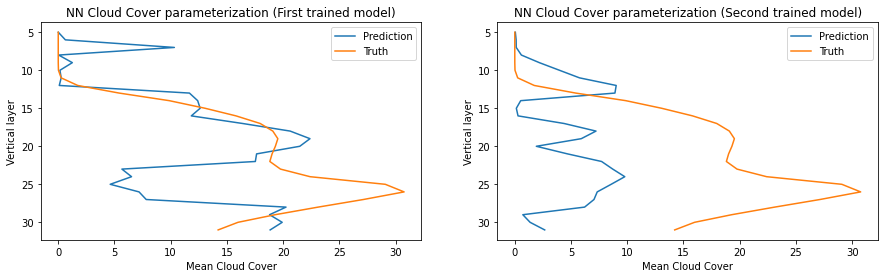

In [76]:
fig = plt.figure(figsize=(15,4))
# For model
ax_1 = fig.add_subplot(121, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (First trained model)')
ax_1.plot(clc_mean, a)
ax_1.plot(clc_data_mean, a)
plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
# For model_2
ax_2 = fig.add_subplot(122, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (Second trained model)')
ax_2.plot(clc_mean_2, a)
ax_2.plot(clc_data_mean_2, a)
plt.gca().invert_yaxis()
ax_2.legend(['Prediction', 'Truth'])
fig.savefig('../figures/qubicc_offline_testing_mean_cloud_cover_NNs_southern_ocean_nov_20s.pdf')

In [28]:
print(list(clc_mean))
print(list(clc_mean_2))
print(clc_data_mean)

[0.0045194151934104775, 0.6318614065888846, 10.32497649476648, 0.03882445186761386, 1.2537582604473434, 0.152621928088619, 0.26000261979146644, 0.09210019328832553, 11.664419551758263, 12.398416727381322, 12.61783093570755, 11.83260971379669, 16.38910575351889, 20.620526117865808, 22.38518482204414, 21.47724071682821, 17.637234797751276, 17.525428161313855, 5.660833960297633, 6.5186304561662585, 4.620117791026004, 7.184569515680412, 7.82142305116748, 20.252684551282673, 18.791656444881212, 19.91301921696601, 18.844414612157234]
[0.04896043607161282, 0.11947702673682006, 0.12904264586741987, 0.585762119119344, 2.183838924182389, 3.969678828003745, 5.755280260956114, 9.016875177810542, 8.905317573625153, 0.5255119806311676, 0.13730439945871295, 0.2870793449206338, 4.377128412460177, 7.222074130012235, 5.91015199389334, 1.914127389559294, 4.689562227110276, 7.718641743257064, 8.709338331942478, 9.78179532437874, 8.567916316626986, 7.329339173019359, 7.042388409632471, 6.207868012299399, 0